## Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingClassifier
import random
from sklearn.utils import resample
from keras import backend as K
import tensorflow as tf
import datetime

random.seed(69)

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

# Leitura do ficheiro

In [3]:
file = data_folder / "Diarios_final.feather"
QuebrasFinal = pd.read_feather(file)

file = data_folder / "EventosFinalComClusterConcelhos.feather"
evento = pd.read_feather(file)
evento.rename(columns = {"data_do_incidente":"date"}, inplace=True)

In [4]:
QuebrasFinal.columns

Index(['concelho', 'distrito', 'date', 't_med', 't_max', 't_min', 'dd_med',
       'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'populacao_residente', 'setor_primario',
       'setor_secundario', 'setor_terciario', 'indice_de_envelhecimento',
       'rural', 'count_zonaa', 'count_zonab', 'count_zonac',
       'total_concelho_zonas', 'percentagem_zonaa', 'percentagem_zonab',
       'percentagem_zonac', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'perc_prim', 'perc_sec', 'perc_terc',
       'minheight', 'maxheight'],
      dtype='object')

## Percentagem Zonas Rurais (NEW)

In [5]:
file = data_folder / "ZonasRuraisPercentagem.feather"
RuraisPerc = pd.read_feather(file)
RuraisPerc

,distrito,concelho,percentagem_area_rural
0,Santarém,Abrantes,82.732312
1,Guarda,Aguiar Da Beira,100.000000
2,Évora,Alandroal,100.000000
3,Aveiro,Albergaria-A-Velha,100.000000
4,Faro,Albufeira,56.419396
...,...,...,...
273,Viseu,Vouzela,100.000000
274,Aveiro,Águeda,100.000000
275,Évora,Évora,91.426395
276,Aveiro,Ílhavo,0.000000


In [6]:
RuraisPerc["concelho"] = RuraisPerc["concelho"].str.upper()
RuraisPerc["distrito"] = RuraisPerc["distrito"].str.upper()

def remover_pontuacao(text):
    text = text.replace('Ç', 'C').replace('Ã', 'A').replace('É', 'E').replace('Â', 'A').replace('Ô', 'O').replace('Á', 'A').replace('Ú', 'U').replace('Ê', 'E').replace('Ó', 'O').replace('Í', 'I')
    return text

RuraisPerc["concelho"] = RuraisPerc["concelho"].apply(remover_pontuacao)
RuraisPerc["concelho"] = RuraisPerc["concelho"].str.replace('-', ' ')
RuraisPerc["concelho"] = RuraisPerc["concelho"].str.replace(' ', '')
RuraisPerc["distrito"] = RuraisPerc["distrito"].apply(remover_pontuacao)
RuraisPerc["distrito"] = RuraisPerc["distrito"].str.replace('-', ' ')
RuraisPerc

,distrito,concelho,percentagem_area_rural
0,SANTAREM,ABRANTES,82.732312
1,GUARDA,AGUIARDABEIRA,100.000000
2,EVORA,ALANDROAL,100.000000
3,AVEIRO,ALBERGARIAAVELHA,100.000000
4,FARO,ALBUFEIRA,56.419396
...,...,...,...
273,VISEU,VOUZELA,100.000000
274,AVEIRO,AGUEDA,100.000000
275,EVORA,EVORA,91.426395
276,AVEIRO,ILHAVO,0.000000


In [7]:
concelho_to_percentagem = RuraisPerc.set_index('concelho')['percentagem_area_rural'].to_dict()
QuebrasFinal['percentagem_area_rural'] = QuebrasFinal['concelho'].map(concelho_to_percentagem)
QuebrasFinal

,concelho,distrito,date,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonab,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural
0,ALMADA,SETUBAL,2018-01-01,8.8,17.8,2.7,273.50,292.5,1.700,6.725,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0
1,ALMADA,SETUBAL,2018-01-02,10.7,17.4,2.6,278.25,289.5,2.000,7.800,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0
2,ALMADA,SETUBAL,2018-01-03,14.7,17.5,10.2,291.25,320.5,2.050,6.200,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0
3,ALMADA,SETUBAL,2018-01-04,15.0,20.3,12.9,255.25,244.5,2.625,7.450,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0
4,ALMADA,SETUBAL,2018-01-05,12.8,15.7,9.5,245.25,194.0,3.575,11.200,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,VISEU,2023-12-27,7.3,12.6,2.8,133.00,90.0,2.600,5.700,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0
560892,RESENDE,VISEU,2023-12-28,8.8,10.7,7.2,202.00,208.0,2.300,5.500,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0
560893,RESENDE,VISEU,2023-12-29,9.3,11.9,7.9,157.00,231.0,1.400,3.700,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0
560894,RESENDE,VISEU,2023-12-30,9.0,9.7,7.6,191.00,219.0,2.600,8.300,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0


In [8]:
QuebrasFinal[QuebrasFinal["percentagem_area_rural"].isnull()]

,concelho,distrito,date,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonab,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural


## Colocar o numero de quebras energeticas que ocorreram em cada dia

In [9]:
QuebrasFinal.set_index(["concelho", 'date'], inplace=True)
evento.set_index(['concelho', 'date'], inplace=True)

QuebrasFinal["n_incidentes"] = 0

# Iterando sobre os índices do DataFrame evento e atualizando QuebrasFinal
for index in evento.index:
    # Incrementando o contador de incidentes em QuebrasFinal
    QuebrasFinal.loc[index, "n_incidentes"] += 1
QuebrasFinal = QuebrasFinal.reset_index()
QuebrasFinal

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural,n_incidentes
0,ALMADA,2018-01-01,SETUBAL,8.8,17.8,2.7,273.50,292.5,1.700,6.725,...,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0,0
1,ALMADA,2018-01-02,SETUBAL,10.7,17.4,2.6,278.25,289.5,2.000,7.800,...,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0,1
2,ALMADA,2018-01-03,SETUBAL,14.7,17.5,10.2,291.25,320.5,2.050,6.200,...,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0,0
3,ALMADA,2018-01-04,SETUBAL,15.0,20.3,12.9,255.25,244.5,2.625,7.450,...,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0,0
4,ALMADA,2018-01-05,SETUBAL,12.8,15.7,9.5,245.25,194.0,3.575,11.200,...,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,2023-12-27,VISEU,7.3,12.6,2.8,133.00,90.0,2.600,5.700,...,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0,0
560892,RESENDE,2023-12-28,VISEU,8.8,10.7,7.2,202.00,208.0,2.300,5.500,...,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0,0
560893,RESENDE,2023-12-29,VISEU,9.3,11.9,7.9,157.00,231.0,1.400,3.700,...,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0,0
560894,RESENDE,2023-12-30,VISEU,9.0,9.7,7.6,191.00,219.0,2.600,8.300,...,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,100.0,0


In [10]:
QuebrasFinal['n_incidentes'].unique()

array([0, 1, 3, 2, 4], dtype=int64)

In [11]:
QuebrasFinal.dtypes

concelho                             object
date                         datetime64[ns]
distrito                             object
t_med                               float64
t_max                               float64
t_min                               float64
dd_med                              float64
dd_ffx                              float64
ff_med                              float64
ff_max                              float64
pr_qtd                              float64
dd_med_sin                          float64
dd_med_cos                          float64
dd_ffx_sin                          float64
dd_ffx_cos                          float64
sen_ano                             float64
cos_ano                             float64
sen_mes                             float64
cos_mes                             float64
densidade_populacional              float64
populacao_residente                 float64
setor_primario                      float64
setor_secundario                

## Estandardizar/Normalizar os dados

In [12]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas = colunas_numericas.drop('n_incidentes', errors='ignore')
colunas_numericas

Index(['t_med', 't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med', 'ff_max',
       'pr_qtd', 'dd_med_sin', 'dd_med_cos', 'dd_ffx_sin', 'dd_ffx_cos',
       'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes', 'densidade_populacional',
       'populacao_residente', 'setor_primario', 'setor_secundario',
       'setor_terciario', 'indice_de_envelhecimento', 'rural', 'count_zonaa',
       'count_zonab', 'count_zonac', 'total_concelho_zonas',
       'percentagem_zonaa', 'percentagem_zonab', 'percentagem_zonac',
       'soma_degree_rede_concelho', 'n_subestacoes_concelho', 'perc_prim',
       'perc_sec', 'perc_terc', 'minheight', 'maxheight',
       'percentagem_area_rural'],
      dtype='object')

In [13]:
# Criar um backup para a previsão real mais à frente
QuebrasFinalBckUp = QuebrasFinal.copy()

# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural,n_incidentes
0,ALMADA,2018-01-01,SETUBAL,-1.231167,-0.510624,-1.608716,0.581558,0.639467,-0.910504,-0.822632,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0
1,ALMADA,2018-01-02,SETUBAL,-0.890658,-0.567731,-1.628273,0.625958,0.610061,-0.694525,-0.507403,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1
2,ALMADA,2018-01-03,SETUBAL,-0.173798,-0.553454,-0.141953,0.747473,0.913921,-0.658529,-0.976581,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0
3,ALMADA,2018-01-04,SETUBAL,-0.120033,-0.153707,0.386081,0.410970,0.168973,-0.244570,-0.610036,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0
4,ALMADA,2018-01-05,SETUBAL,-0.514307,-0.810434,-0.278851,0.317498,-0.326025,0.439363,0.489598,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,2023-12-27,VISEU,-1.499990,-1.253012,-1.589159,-0.731735,-1.345427,-0.262568,-1.123199,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0
560892,RESENDE,2023-12-28,VISEU,-1.231167,-1.524269,-0.728658,-0.086772,-0.188798,-0.478546,-1.181846,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0
560893,RESENDE,2023-12-29,VISEU,-1.141560,-1.352949,-0.591760,-0.507400,0.036647,-1.126482,-1.709670,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0
560894,RESENDE,2023-12-30,VISEU,-1.195324,-1.667036,-0.650431,-0.189592,-0.080976,-0.262568,-0.360786,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0


In [14]:
QuebrasFinal.groupby(["n_incidentes"])["n_incidentes"].count()

n_incidentes
0    558072
1      2737
2        77
3         9
4         1
Name: n_incidentes, dtype: int64

# Modelling

In [15]:
QuebrasFinal["HouveEvento?"] = np.where(QuebrasFinal["n_incidentes"] > 0, 1, 0)
QuebrasFinal

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural,n_incidentes,HouveEvento?
0,ALMADA,2018-01-01,SETUBAL,-1.231167,-0.510624,-1.608716,0.581558,0.639467,-0.910504,-0.822632,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
1,ALMADA,2018-01-02,SETUBAL,-0.890658,-0.567731,-1.628273,0.625958,0.610061,-0.694525,-0.507403,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1,1
2,ALMADA,2018-01-03,SETUBAL,-0.173798,-0.553454,-0.141953,0.747473,0.913921,-0.658529,-0.976581,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
3,ALMADA,2018-01-04,SETUBAL,-0.120033,-0.153707,0.386081,0.410970,0.168973,-0.244570,-0.610036,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
4,ALMADA,2018-01-05,SETUBAL,-0.514307,-0.810434,-0.278851,0.317498,-0.326025,0.439363,0.489598,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,2023-12-27,VISEU,-1.499990,-1.253012,-1.589159,-0.731735,-1.345427,-0.262568,-1.123199,...,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0
560892,RESENDE,2023-12-28,VISEU,-1.231167,-1.524269,-0.728658,-0.086772,-0.188798,-0.478546,-1.181846,...,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0
560893,RESENDE,2023-12-29,VISEU,-1.141560,-1.352949,-0.591760,-0.507400,0.036647,-1.126482,-1.709670,...,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0
560894,RESENDE,2023-12-30,VISEU,-1.195324,-1.667036,-0.650431,-0.189592,-0.080976,-0.262568,-0.360786,...,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0


In [16]:
teste = QuebrasFinal[(QuebrasFinal["concelho"] == "LISBOA")]
# teste = QuebrasFinal
teste

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural,n_incidentes,HouveEvento?
81067,LISBOA,2018-01-01,LISBOA,-0.657679,-0.724774,-0.552647,0.614274,0.418923,-1.054489,-0.741992,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
81068,LISBOA,2018-01-02,LISBOA,-0.478464,-0.781881,-0.357078,0.539496,0.801199,-0.838511,-0.771316,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
81069,LISBOA,2018-01-03,LISBOA,-0.209641,-0.624837,0.386081,0.679705,0.801199,-0.622532,-1.035228,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
81070,LISBOA,2018-01-04,LISBOA,-0.245484,-0.724774,0.464309,0.371244,0.360111,-0.118582,-0.478080,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
81071,LISBOA,2018-01-05,LISBOA,-0.585993,-0.896095,-0.357078,0.717094,-0.022165,0.457361,1.281335,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83253,LISBOA,2023-12-27,LISBOA,-1.428304,-1.681313,-1.022011,-1.376697,-1.404239,0.529354,-0.683345,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
83254,LISBOA,2023-12-28,LISBOA,-1.051952,-1.238735,-0.689545,-1.414086,-1.727703,-0.046589,-0.947257,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
83255,LISBOA,2023-12-29,LISBOA,-1.016109,-1.338672,-0.435306,-1.442128,-1.786515,-0.190575,-1.005904,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0
83256,LISBOA,2023-12-30,LISBOA,-0.854815,-0.938925,-0.806886,-1.507559,-1.404239,-0.694525,-1.299140,...,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,-2.330552,0,0


## Prever Número Absoluto

In [17]:
# Selecionar apenas as colunas relevantes
features = ['t_med', 't_max', 't_min', 'ff_med', 
            'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'indice_de_envelhecimento',
       'percentagem_area_rural', 'percentagem_zonaa', 'percentagem_zonab', 'percentagem_zonac',
       'total_concelho_zonas', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'setor_primario', 'setor_secundario',
       'setor_terciario', 'minheight', 'maxheight']
target = 'n_incidentes'

### Teste 1 - LSTM Normal

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

# Suponha que "teste" é o seu DataFrame original que contém a coluna "concelho"
# e "features" e "target" são definidos anteriormente

# Dividir os dados em conjunto de treinamento e teste
X = teste[features].values
y = teste[target].values
concelhos = teste['concelho'].values  # Adicionar coluna concelho

X_train, X_test, y_train, y_test, concelhos_train, concelhos_test = train_test_split(
    X, y, concelhos, test_size=0.2, random_state=42
)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=20, batch_size=32,
    validation_split=0.2,
    verbose=1,
)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# Prever os valores para o conjunto de teste
y_predicted = model.predict(X_test)

# Adicionar coluna "concelho" aos dados de teste
concelho_series = pd.Series(concelhos_test, name='concelho')
X_test_with_concelho = pd.DataFrame(X_test, columns=features).join(concelho_series)

# Criar um novo DataFrame com todas as colunas iniciais, os valores reais e os valores previstos
predicted_df = pd.concat([X_test_with_concelho, pd.DataFrame(y_test, columns=['real_' + target]), pd.DataFrame(y_predicted, columns=['predicted_' + target])], axis=1)

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1208 - val_loss: 0.0705
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0756 - val_loss: 0.0492
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0601 - val_loss: 0.0409
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0484 - val_loss: 0.0379
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0544 - val_loss: 0.0367
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0528 - val_loss: 0.0364
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0488 - val_loss: 0.0364
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0493 - val_loss: 0.0362
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0415 - val_loss: 0.0361
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0522 - val_loss: 0.0360
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0369 - val_loss: 0.0362
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0512 - val_loss: 0.03

In [19]:
predicted_df

,t_med,t_max,t_min,ff_med,ff_max,pr_qtd,dd_med_sin,dd_med_cos,dd_ffx_sin,dd_ffx_cos,...,soma_degree_rede_concelho,n_subestacoes_concelho,setor_primario,setor_secundario,setor_terciario,minheight,maxheight,concelho,real_n_incidentes,predicted_n_incidentes
0,-1.394442,-1.354092,-1.370619,-0.481870,-0.452775,0.620385,1.431230,-0.020550,-0.715692,-1.370566,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041674
1,0.473451,0.395991,0.647432,-0.220793,0.033200,-0.278634,1.208629,-0.809639,0.976291,-0.789644,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041674
2,1.152685,1.027965,1.122268,1.084592,0.519174,-0.278634,-1.036574,0.892332,-0.293874,1.341695,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041674
3,1.152685,1.027965,1.027301,0.388387,0.389581,-0.278634,-1.028460,-0.980644,0.976291,-0.789644,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041674
4,-1.054825,-0.867958,-1.038234,1.084592,-0.452775,-0.278634,0.639278,1.243276,0.990554,0.684887,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,-0.269461,-0.576278,0.053888,-0.307818,-0.420376,-0.206713,-1.330636,0.328518,1.067383,0.555966,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041675
435,-0.948695,-0.608687,-1.655520,0.475412,0.065598,-0.278634,0.407122,-1.411572,0.717828,0.984916,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041675
436,-0.248235,0.152924,-0.563399,-0.916998,-1.133139,-0.278634,-0.758397,1.142725,-1.796846,0.086418,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,0,0.041675
437,-2.031224,-1.840226,-1.869196,1.345669,0.162793,-0.278634,0.200149,-1.453950,0.717828,0.984916,...,4.245493e-13,5.151435e-14,-4.640732e-14,1.021405e-14,4.476419e-13,2.731149e-14,-2.498002e-14,LISBOA,1,0.041675


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import numpy as np

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular o erro absoluto percentual médio (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calcular o desvio médio absoluto (MBD)
mbd = np.mean(y_pred - y_test)
print(f'Mean Bias Deviation (MBD): {mbd}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Calcular a variância explicada
explained_variance = explained_variance_score(y_test, y_pred)
print(f'Explained Variance Score: {explained_variance}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE): 0.06096142499433675
Root Mean Squared Error (RMSE): 0.24690367553832962
Mean Absolute Error (MAE): 0.09216722159525528
Mean Absolute Percentage Error (MAPE): 178279430301756.72
Mean Bias Deviation (MBD): -0.012995250260028861
R-squared (R²): -0.0027779776658904964
Explained Variance Score: -6.254065731958747e-08


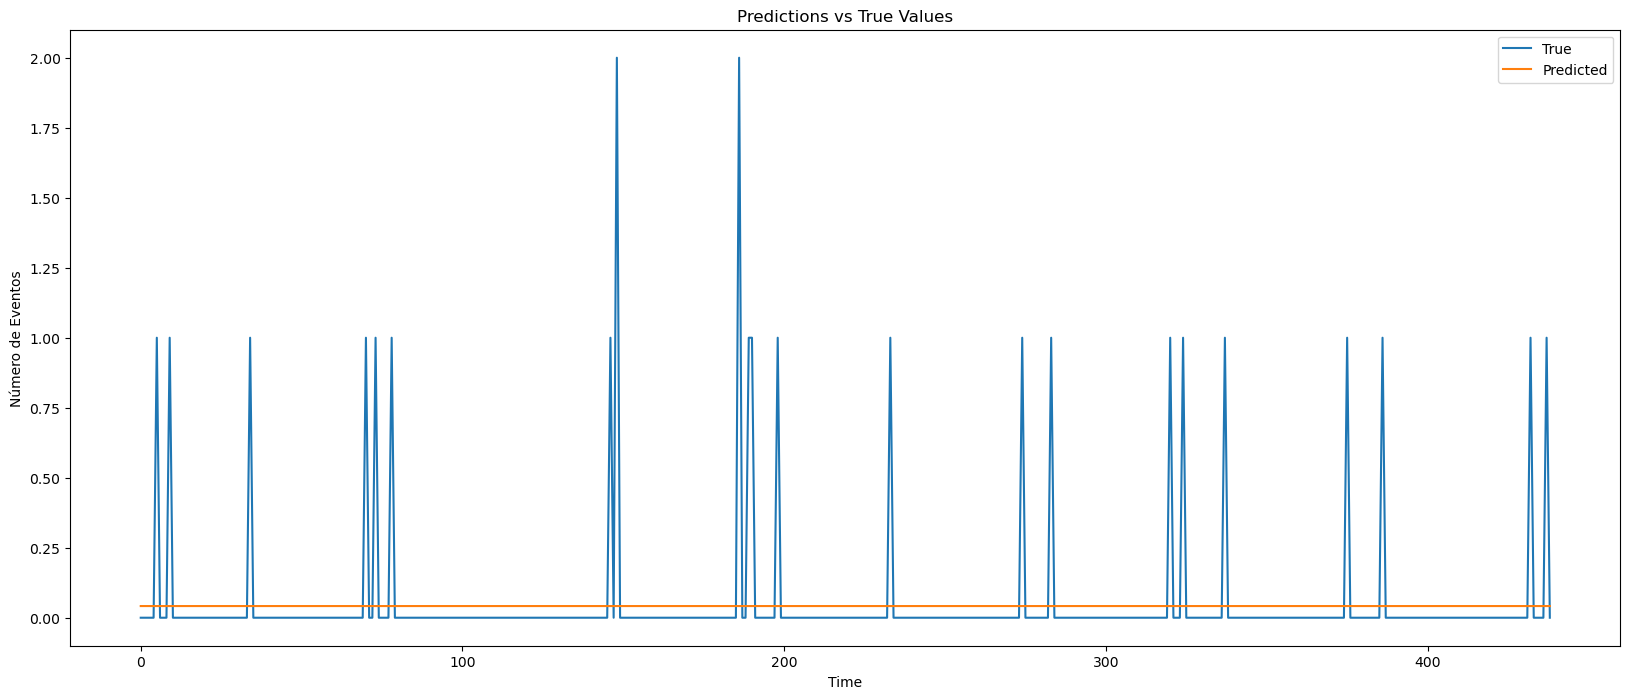

In [21]:
#### Plotar as previsões vs. os valores reais
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcountNormal')
plt.show()

### teste 2 - Pesos nas classes

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

# Suponha que "teste" é o seu DataFrame original que contém a coluna "concelho"
# e "features" e "target" são definidos anteriormente

# Dividir os dados em conjunto de treinamento e teste
X = teste[features].values
y = teste[target].values
concelhos = teste['concelho'].values  # Adicionar coluna concelho

X_train, X_test, y_train, y_test, concelhos_train, concelhos_test = train_test_split(
    X, y, concelhos, test_size=0.2, random_state=42
)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular a proporção de classes para os pesos das amostras
class_weights = compute_sample_weight('balanced', y_train)

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=20, batch_size=32,
    validation_split=0.2,
    verbose=1,
    sample_weight=class_weights
)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# Prever os valores para o conjunto de teste
y_predicted = model.predict(X_test)

# Adicionar coluna "concelho" aos dados de teste
concelho_series = pd.Series(concelhos_test, name='concelho')
X_test_with_concelho = pd.DataFrame(X_test, columns=features).join(concelho_series)

# Criar um novo DataFrame com todas as colunas iniciais, os valores reais e os valores previstos
predicted_df = pd.concat([X_test_with_concelho, pd.DataFrame(y_test, columns=['real_' + target]), pd.DataFrame(y_predicted, columns=['predicted_' + target])], axis=1)

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.2661 - val_loss: 0.3804
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8615 - val_loss: 0.5150
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1329 - val_loss: 0.2770
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7024 - val_loss: 0.3719
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9126 - val_loss: 0.3902
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0113 - val_loss: 0.3367
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0600 - val_loss: 0.4032
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5795 - val_loss: 0.3421
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5510 - val_loss: 0.3109
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6526 - val_loss: 0.5118
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7273 - val_loss: 0.4349
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7019 - val_loss: 0.3

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import numpy as np

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular o erro absoluto percentual médio (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calcular o desvio médio absoluto (MBD)
mbd = np.mean(y_pred - y_test)
print(f'Mean Bias Deviation (MBD): {mbd}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Calcular a variância explicada
explained_variance = explained_variance_score(y_test, y_pred)
print(f'Explained Variance Score: {explained_variance}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE): 1.0862581582191717
Root Mean Squared Error (RMSE): 1.042237093093108
Mean Absolute Error (MAE): 1.0202951109490797
Mean Absolute Percentage Error (MAPE): 4562615280385861.0
Mean Bias Deviation (MBD): 1.0117640531959187
R-squared (R²): -16.868279149040372
Explained Variance Score: -0.029594323229944264


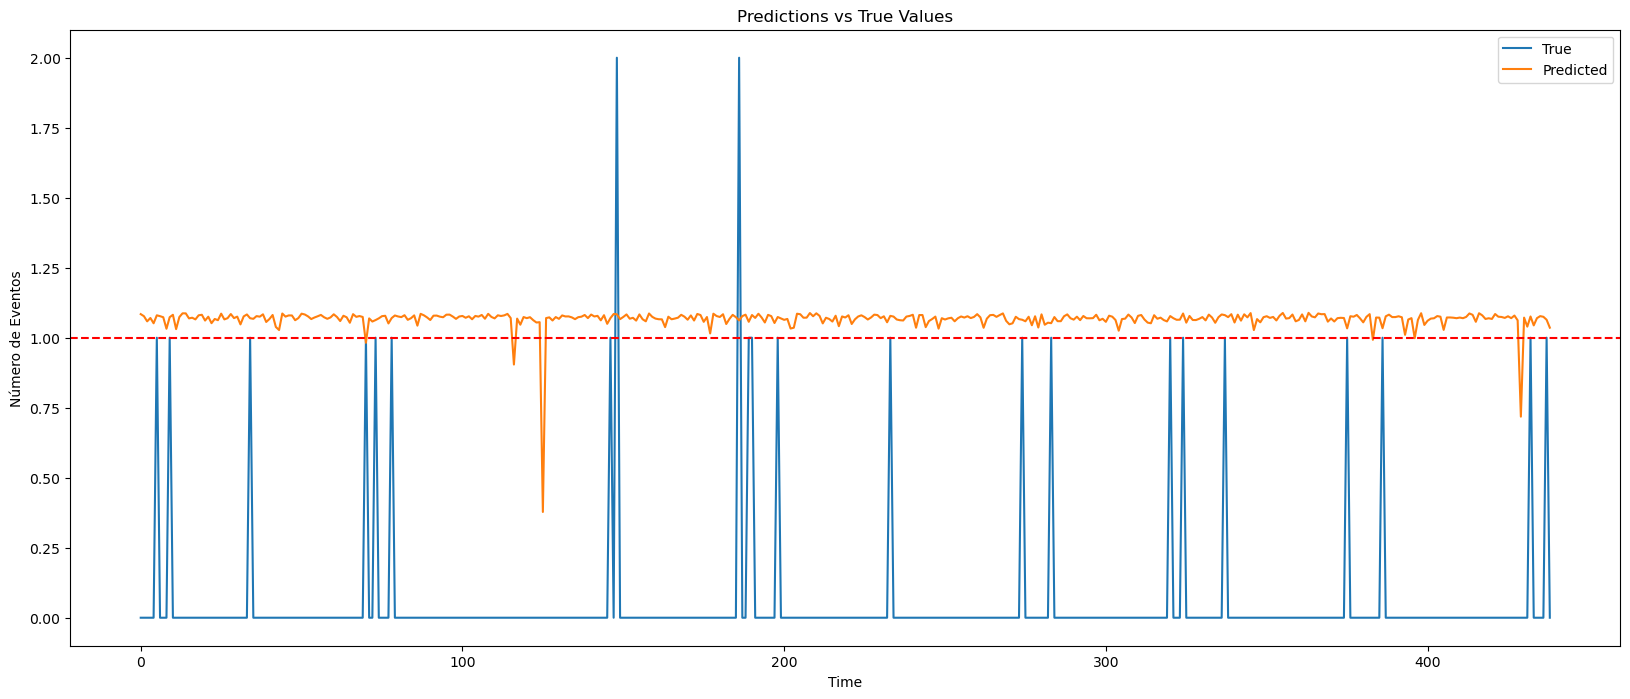

In [24]:
#### Plotar as previsões vs. os valores reais
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcountWeight')
plt.show()

### Teste 3 - SMOTE

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from imblearn.over_sampling import SMOTE

# Suponha que "teste" é o seu DataFrame original que contém a coluna "concelho"
# e "features" e "target" são definidos anteriormente

# Dividir os dados em conjunto de treinamento e teste
X = teste[features].values
y = teste[target].values
concelhos = teste['concelho'].values  # Adicionar coluna concelho

X_train, X_test, y_train, y_test, concelhos_train, concelhos_test = train_test_split(
    X, y, concelhos, test_size=0.2, random_state=42
)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aplicar SMOTE para oversampling da classe minoritária
smote = SMOTE(k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizar os dados de entrada novamente após o resampling
X_train_resampled = scaler.transform(X_train_resampled)

# Calcular a proporção de classes para os pesos das amostras resampleadas
class_weights_resampled = compute_sample_weight('balanced', y_train_resampled)

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train_resampled.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=20, batch_size=32,
    validation_split=0.2,
    verbose=1,
    sample_weight=class_weights_resampled
)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# Prever os valores para o conjunto de teste
y_predicted = model.predict(X_test)

# Adicionar coluna "concelho" aos dados de teste
concelho_series = pd.Series(concelhos_test, name='concelho')
X_test_with_concelho = pd.DataFrame(X_test, columns=features).join(concelho_series)

# Criar um novo DataFrame com todas as colunas iniciais, os valores reais e os valores previstos
predicted_df = pd.concat([X_test_with_concelho, pd.DataFrame(y_test, columns=['real_' + target]), pd.DataFrame(y_predicted, columns=['predicted_' + target])], axis=1)

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6516 - val_loss: 1.7524
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6014 - val_loss: 1.4176
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5486 - val_loss: 0.7863
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4827 - val_loss: 1.0574
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4621 - val_loss: 0.4132
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4559 - val_loss: 1.3312
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4290 - val_loss: 0.9058
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3890 - val_loss: 0.3621
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3543 - val_loss: 0.3109
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3467 - val_loss: 0.2283
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3208 - val_loss: 0.1942
Epoch 12/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import numpy as np

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular o erro absoluto percentual médio (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calcular o desvio médio absoluto (MBD)
mbd = np.mean(y_pred - y_test)
print(f'Mean Bias Deviation (MBD): {mbd}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Calcular a variância explicada
explained_variance = explained_variance_score(y_test, y_pred)
print(f'Explained Variance Score: {explained_variance}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE): 0.5777333252402742
Root Mean Squared Error (RMSE): 0.7600877089127769
Mean Absolute Error (MAE): 0.5642234102943764
Mean Absolute Percentage Error (MAPE): 2309161237330438.0
Mean Bias Deviation (MBD): 0.24337069561242514
R-squared (R²): -8.503358157530801
Explained Variance Score: -7.529072645858278


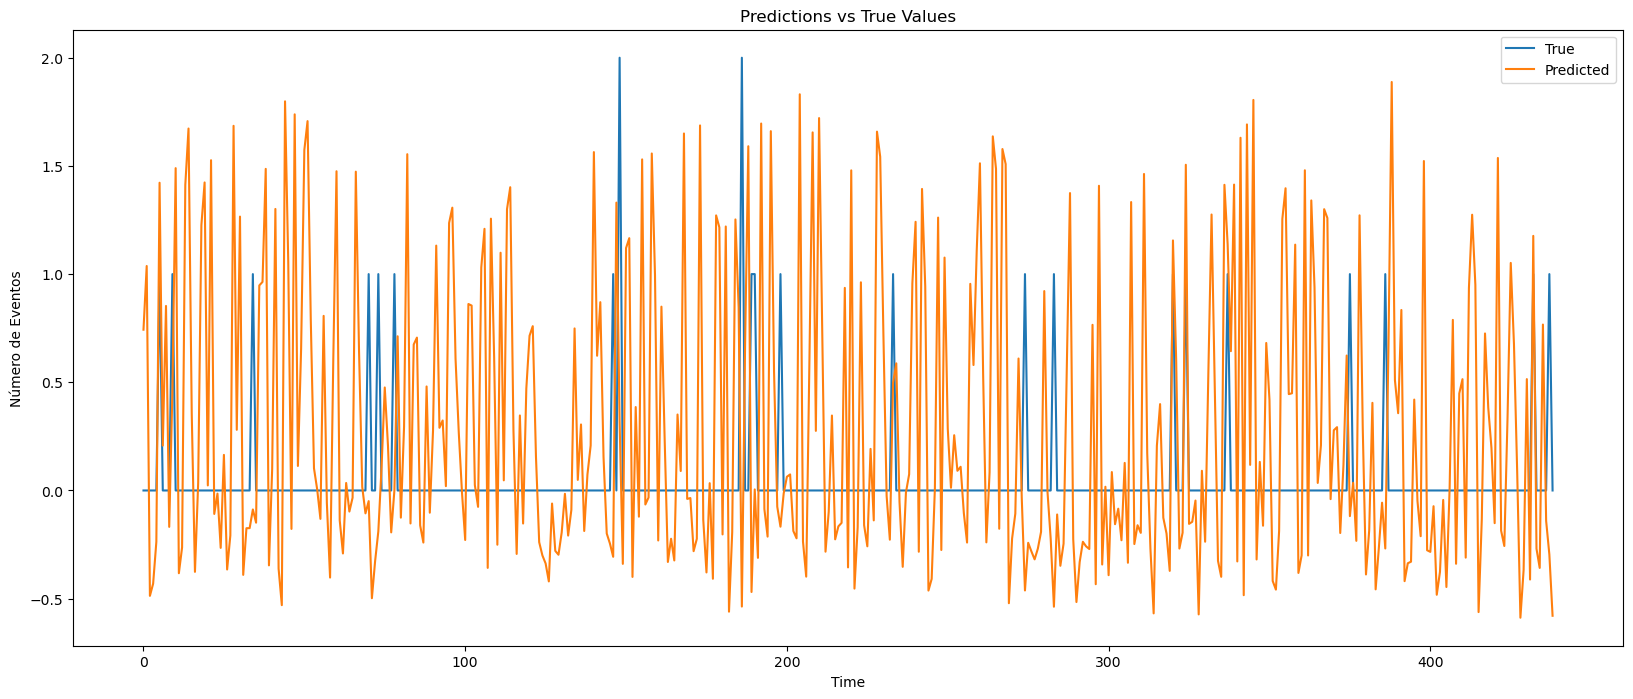

In [27]:
#### Plotar as previsões vs. os valores reais
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcountSMOTE')
plt.show()


In [28]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Prever caso Binário

In [ ]:
QuebrasFinal.groupby(['HouveEvento?'])['HouveEvento?'].count()

In [ ]:
# Selecionar apenas as colunas relevantes
features = ['t_med', 't_max', 't_min', 'ff_med', 
            'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'indice_de_envelhecimento',
       'percentagem_area_rural', 'percentagem_zonaa', 'percentagem_zonab', 'percentagem_zonac',
       'total_concelho_zonas', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'setor_primario', 'setor_secundario',
       'setor_terciario', 'minheight', 'maxheight']
target = 'HouveEvento?'

## Teste 1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

# Suponha que "teste" é o seu DataFrame original que contém a coluna "concelho"
# e "features" e "target" são definidos anteriormente

# Dividir os dados em conjunto de treinamento e teste
X = teste[features].values
y = teste[target].values
concelhos = teste['concelho'].values  # Adicionar coluna concelho

X_train, X_test, y_train, y_test, concelhos_train, concelhos_test = train_test_split(
    X, y, concelhos, test_size=0.2, random_state=42
)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular a proporção de classes para os pesos das amostras
class_weights = compute_sample_weight('balanced', y_train)

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=20, batch_size=32,
    validation_split=0.2,
    verbose=1,
    sample_weight=class_weights
)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# Prever os valores para o conjunto de teste
y_predicted = model.predict(X_test)

# Adicionar coluna "concelho" aos dados de teste
concelho_series = pd.Series(concelhos_test, name='concelho')
X_test_with_concelho = pd.DataFrame(X_test, columns=features).join(concelho_series)

# Criar um novo DataFrame com todas as colunas iniciais, os valores reais e os valores previstos
predicted_df = pd.concat([X_test_with_concelho, pd.DataFrame(y_test, columns=['real_' + target]), pd.DataFrame(y_predicted, columns=['predicted_' + target])], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import numpy as np

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular o erro absoluto percentual médio (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calcular o desvio médio absoluto (MBD)
mbd = np.mean(y_pred - y_test)
print(f'Mean Bias Deviation (MBD): {mbd}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Calcular a variância explicada
explained_variance = explained_variance_score(y_test, y_pred)
print(f'Explained Variance Score: {explained_variance}')


In [ ]:
###### Plotar as previsões vs. os valores reais
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.axhline(y=0.5, color='r', linestyle='--')
plt.savefig('LSTMBinWeight')
plt.show()

In [ ]:
# Arredondar os valores de y_pred
y_pred[y_pred < 0.5] = 0
y_pred_rounded = y_pred.round()

y_test_flat = y_test.flatten()
y_pred_rounded_flat = y_pred_rounded.flatten()

# Criar um DataFrame com y_test e y_pred_rounded
df_comparison = pd.DataFrame({'True': y_test_flat, 'Predicted': y_pred_rounded_flat})

# Plotar os valores verdadeiros e previstos
plt.figure(figsize=(20, 8))
plt.plot(df_comparison['True'], label='True', linewidth=2)
plt.plot(df_comparison['Predicted'], label='Predicted', linestyle='-', linewidth=1)

# Configurar os rótulos e título do gráfico
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMBinWeightTratado')

# Exibir o gráfico
plt.show()

## Teste 2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from imblearn.over_sampling import SMOTE

# Suponha que "teste" é o seu DataFrame original que contém a coluna "concelho"
# e "features" e "target" são definidos anteriormente

# Dividir os dados em conjunto de treinamento e teste
X = teste[features].values
y = teste[target].values
concelhos = teste['concelho'].values  # Adicionar coluna concelho

X_train, X_test, y_train, y_test, concelhos_train, concelhos_test = train_test_split(
    X, y, concelhos, test_size=0.2, random_state=42
)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aplicar SMOTE para oversampling da classe minoritária
smote = SMOTE(k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizar os dados de entrada novamente após o resampling
X_train_resampled = scaler.transform(X_train_resampled)

# Calcular a proporção de classes para os pesos das amostras resampleadas
class_weights_resampled = compute_sample_weight('balanced', y_train_resampled)

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train_resampled.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=20, batch_size=32,
    validation_split=0.2,
    verbose=1,
    sample_weight=class_weights_resampled
)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# Prever os valores para o conjunto de teste
y_predicted = model.predict(X_test)

# Adicionar coluna "concelho" aos dados de teste
concelho_series = pd.Series(concelhos_test, name='concelho')
X_test_with_concelho = pd.DataFrame(X_test, columns=features).join(concelho_series)

# Criar um novo DataFrame com todas as colunas iniciais, os valores reais e os valores previstos
predicted_df = pd.concat([X_test_with_concelho, pd.DataFrame(y_test, columns=['real_' + target]), pd.DataFrame(y_predicted, columns=['predicted_' + target])], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import numpy as np

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular o erro absoluto percentual médio (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calcular o desvio médio absoluto (MBD)
mbd = np.mean(y_pred - y_test)
print(f'Mean Bias Deviation (MBD): {mbd}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Calcular a variância explicada
explained_variance = explained_variance_score(y_test, y_pred)
print(f'Explained Variance Score: {explained_variance}')


In [ ]:
###### Plotar as previsões vs. os valores reais
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMBinSmote')
plt.show()

# Classificação

In [33]:
# Selecionar apenas as colunas relevantes
features = ['t_med', 't_max', 't_min', 'ff_med', 
            'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'indice_de_envelhecimento',
       'percentagem_area_rural', 'percentagem_zonaa', 'percentagem_zonab', 'percentagem_zonac',
       'total_concelho_zonas', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'setor_primario', 'setor_secundario',
       'setor_terciario', 'minheight', 'maxheight']
target = 'HouveEvento?'
corr =['t_med', 't_max', 't_min', 'ff_med', 
            'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'indice_de_envelhecimento',
       'percentagem_area_rural', 'percentagem_zonaa', 'percentagem_zonab', 'percentagem_zonac',
       'total_concelho_zonas', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'setor_primario', 'setor_secundario',
       'setor_terciario', 'minheight', 'maxheight', 'HouveEvento?']

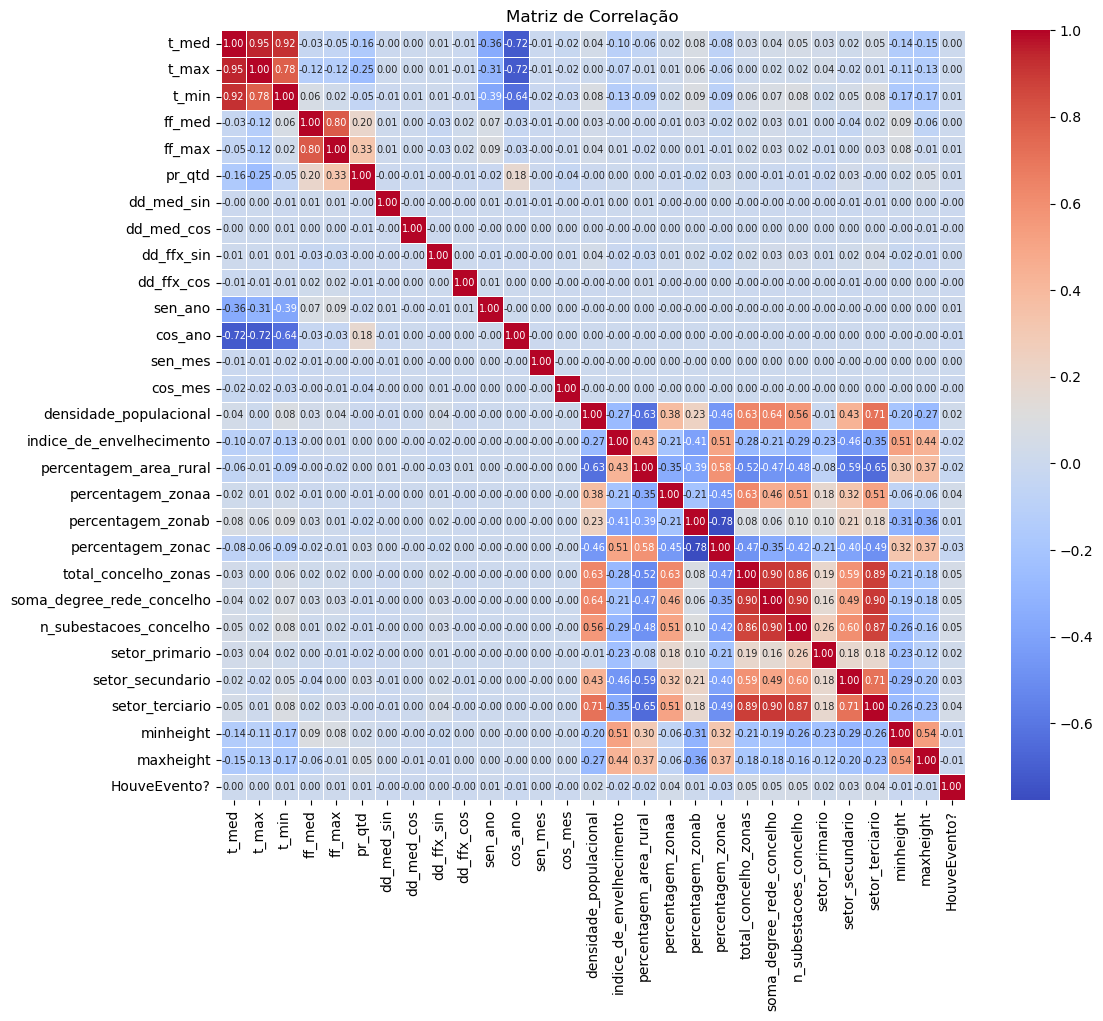

In [34]:
correlation_matrix = QuebrasFinal[corr].corr()
# Passo 5: Plotar um gráfico de correlações
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"fontsize": 7})
plt.title("Matriz de Correlação")
plt.savefig("Matriz de Correlação")
plt.show()

In [35]:
QuebrasFinal.columns

Index(['concelho', 'date', 'distrito', 't_med', 't_max', 't_min', 'dd_med',
       'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'populacao_residente', 'setor_primario',
       'setor_secundario', 'setor_terciario', 'indice_de_envelhecimento',
       'rural', 'count_zonaa', 'count_zonab', 'count_zonac',
       'total_concelho_zonas', 'percentagem_zonaa', 'percentagem_zonab',
       'percentagem_zonac', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'perc_prim', 'perc_sec', 'perc_terc',
       'minheight', 'maxheight', 'percentagem_area_rural', 'n_incidentes',
       'HouveEvento?'],
      dtype='object')

## Original

In [36]:
# Passo 2: Dividir os dados em conjuntos de treino e teste
X = QuebrasFinal.drop(columns=['HouveEvento?', 'n_incidentes', 'concelho', 'date', 'distrito', 'populacao_residente', 'rural', 'count_zonaa', 'count_zonab', 'count_zonac', 'perc_prim', 'perc_sec', 'perc_terc'])
y = QuebrasFinal['HouveEvento?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 3: Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [37]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.9951595649848458
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    111652
           1       0.00      0.00      0.00       528

    accuracy                           1.00    112180
   macro avg       0.50      0.50      0.50    112180
weighted avg       0.99      1.00      0.99    112180



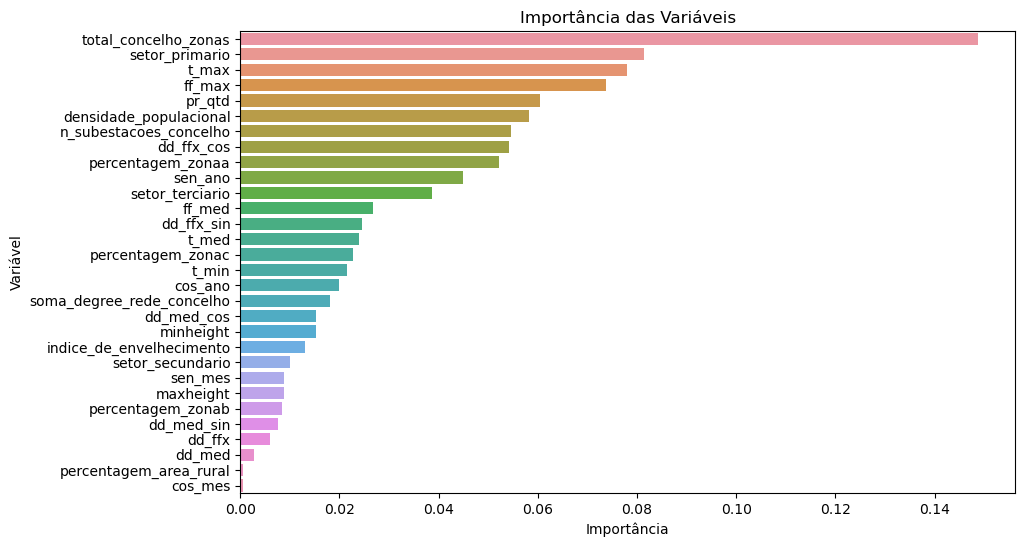

In [38]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig("OGimportanciaVariaveis")
plt.show()


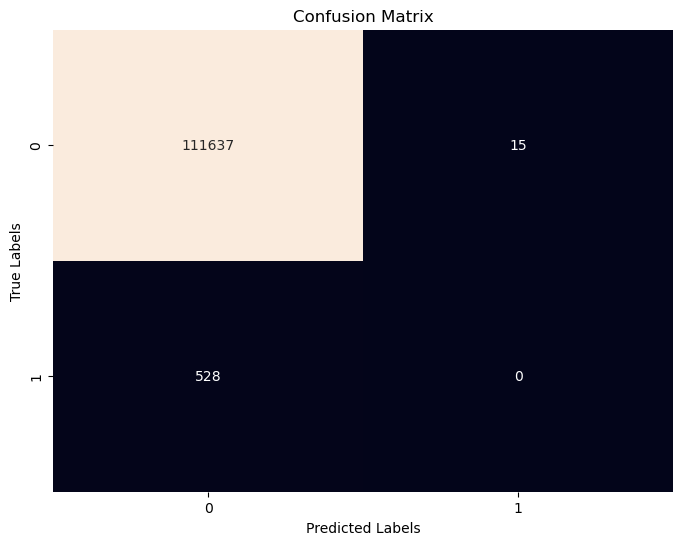

In [39]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OGconfusionMatrix")
plt.show()


## Oversampling

In [57]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEvento?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEvento?'] == 0]

# Fazer oversampling da classe minoritária
oversampled_minor_class = resample(minor_class, replace=True, n_samples=len(major_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária oversampled
oversampled_data = pd.concat([major_class, oversampled_minor_class])

# Separar as features (X) e o target (y)
X = oversampled_data.drop(columns=['HouveEvento?', 'n_incidentes', 'concelho', 'date', 'distrito', 'populacao_residente', 'rural', 'count_zonaa', 'count_zonab', 'count_zonac', 'perc_prim', 'perc_sec', 'perc_terc'])
y = oversampled_data['HouveEvento?']

In [58]:
oversampled_data

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural,n_incidentes,HouveEvento?
0,ALMADA,2018-01-01,SETUBAL,-1.231167,-0.510624,-1.608716,0.581558,0.639467,-0.910504,-0.822632,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
2,ALMADA,2018-01-03,SETUBAL,-0.173798,-0.553454,-0.141953,0.747473,0.913921,-0.658529,-0.976581,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
3,ALMADA,2018-01-04,SETUBAL,-0.120033,-0.153707,0.386081,0.410970,0.168973,-0.244570,-0.610036,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
4,ALMADA,2018-01-05,SETUBAL,-0.514307,-0.810434,-0.278851,0.317498,-0.326025,0.439363,0.489598,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
5,ALMADA,2018-01-06,SETUBAL,-1.159481,-1.210182,-1.002454,1.079301,0.173874,1.177289,1.420622,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390901,CASCAIS,2020-06-22,LISBOA,1.582511,1.787923,1.324809,1.305973,1.242286,-0.406554,0.137715,...,1.963492,2.258602,-1.015774,-1.370429,2.161416,-0.793629,-0.374344,-2.330552,1,1
143962,CHAVES,2022-03-28,VILAREAL,-0.442621,-0.396410,-0.200624,-1.339308,-1.727703,-1.414454,-1.416435,...,0.095661,0.097907,-0.446600,-0.678789,1.032530,1.831519,1.034014,-0.036268,1,1
162793,COIMBRA,2019-10-22,COIMBRA,-0.585993,-0.310750,-0.650431,-1.619726,-1.453249,-0.262568,0.548246,...,1.548418,1.826463,-0.974353,-1.128534,1.872699,-0.714874,-0.313111,-1.019993,1,1
154330,TOMAR,2020-08-18,SANTAREM,1.439139,1.887860,1.422593,0.530148,0.997238,-0.694525,-1.181846,...,-0.319412,0.097907,-0.634227,-0.485281,0.950150,-0.513613,-0.680508,0.264343,1,1


In [59]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [60]:
##### Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.7021713128670558
Precisão: 0.6925806451612904
Recall: 0.7293842082677728
F1-score: 0.7105061483261922
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.71      0.67      0.69    111373
           1       0.69      0.73      0.71    111856

    accuracy                           0.70    223229
   macro avg       0.70      0.70      0.70    223229
weighted avg       0.70      0.70      0.70    223229



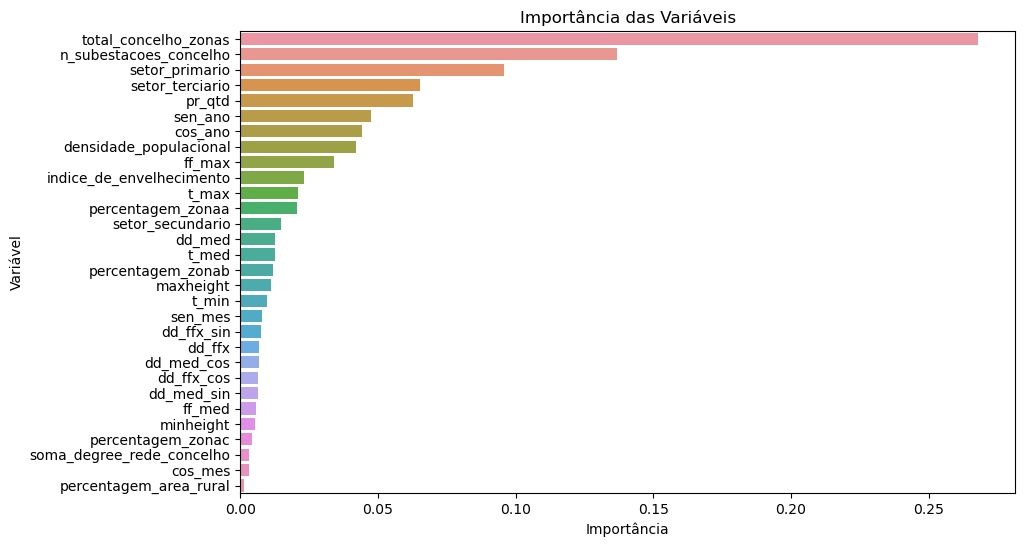

In [61]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig('OVEReatureImportance.png', format='png', bbox_inches='tight')
plt.show()


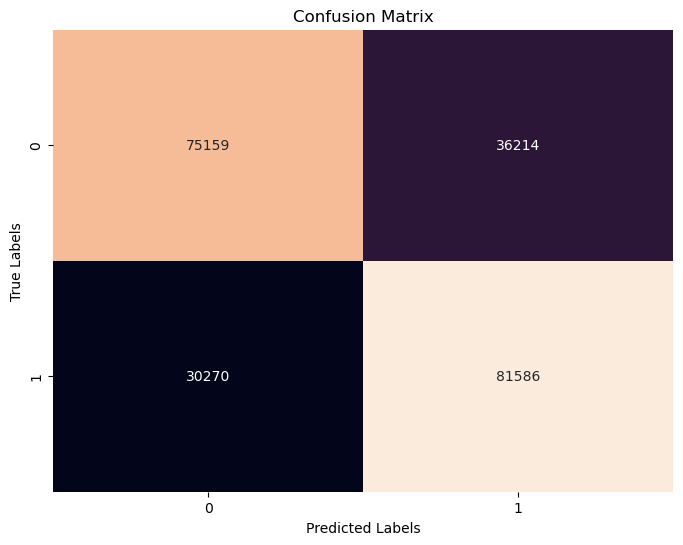

In [62]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [63]:
conf_matrix

array([[75159, 36214],
       [30270, 81586]], dtype=int64)

### Previsão da DB original - Modelo Over

In [64]:
X = QuebrasFinal.drop(columns=['HouveEvento?', 'n_incidentes', 'concelho', 'date', 'distrito', 'populacao_residente', 'rural', 'count_zonaa', 'count_zonab', 'count_zonac', 'perc_prim', 'perc_sec', 'perc_terc'])
y = QuebrasFinal['HouveEvento?']

# Fazer previsões na base de dados original
predictions = gb_model.predict(X)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions)
recall = recall_score(y, predictions)
f1 = f1_score(y, predictions)

print(f"Acurácia: {accuracy:.3f}")
print(f"Precisão: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Acurácia: 0.675
Precisão: 0.011
Recall: 0.728
F1-score: 0.022


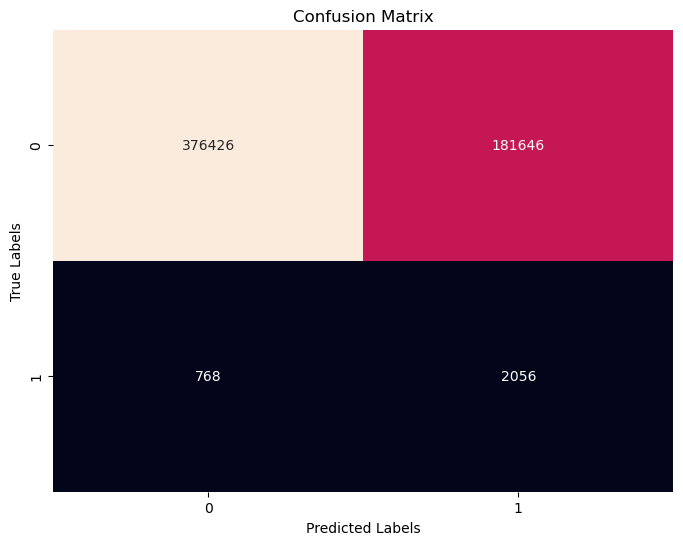

In [65]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y, predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OVERconfusionMatrix.png", format='png', bbox_inches='tight')
plt.show()

In [70]:
QuebrasFinal["previsao"] = predictions
QuebrasFinal

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural,n_incidentes,HouveEvento?,previsao
0,ALMADA,2018-01-01,SETUBAL,-1.231167,-0.510624,-1.608716,0.581558,0.639467,-0.910504,-0.822632,...,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0,1
1,ALMADA,2018-01-02,SETUBAL,-0.890658,-0.567731,-1.628273,0.625958,0.610061,-0.694525,-0.507403,...,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1,1,1
2,ALMADA,2018-01-03,SETUBAL,-0.173798,-0.553454,-0.141953,0.747473,0.913921,-0.658529,-0.976581,...,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0,1
3,ALMADA,2018-01-04,SETUBAL,-0.120033,-0.153707,0.386081,0.410970,0.168973,-0.244570,-0.610036,...,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0,0
4,ALMADA,2018-01-05,SETUBAL,-0.514307,-0.810434,-0.278851,0.317498,-0.326025,0.439363,0.489598,...,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,2023-12-27,VISEU,-1.499990,-1.253012,-1.589159,-0.731735,-1.345427,-0.262568,-1.123199,...,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0,0
560892,RESENDE,2023-12-28,VISEU,-1.231167,-1.524269,-0.728658,-0.086772,-0.188798,-0.478546,-1.181846,...,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0,0
560893,RESENDE,2023-12-29,VISEU,-1.141560,-1.352949,-0.591760,-0.507400,0.036647,-1.126482,-1.709670,...,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0,0
560894,RESENDE,2023-12-30,VISEU,-1.195324,-1.667036,-0.650431,-0.189592,-0.080976,-0.262568,-0.360786,...,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0.510070,0,0,0


In [72]:
# Cria uma nova coluna com o número da semana e o ano
QuebrasFinal['semana'] = QuebrasFinal['date'].dt.isocalendar().week
QuebrasFinal['ano'] = QuebrasFinal['date'].dt.year

# Agrupa pelos campos "distrito", "concelho", "ano" e "semana", e calcula a soma da coluna "previsao"
SemanaEnergia = QuebrasFinal.groupby(['distrito', 'concelho', 'ano', 'semana'])['previsao'].sum().reset_index()
SemanaEnergia

,distrito,concelho,ano,semana,previsao
0,AVEIRO,AGUEDA,2018,1,1
1,AVEIRO,AGUEDA,2018,2,1
2,AVEIRO,AGUEDA,2018,3,0
3,AVEIRO,AGUEDA,2018,4,1
4,AVEIRO,AGUEDA,2018,5,2
...,...,...,...,...,...
80379,VISEU,VOUZELA,2023,48,0
80380,VISEU,VOUZELA,2023,49,0
80381,VISEU,VOUZELA,2023,50,0
80382,VISEU,VOUZELA,2023,51,0


In [74]:
SemanaEnergia["previsao"].unique()

array([1, 0, 2, 7, 6, 4, 5, 3, 8])

In [75]:
SemanaEnergia["previsao"].value_counts()

previsao
0    43495
7    17805
1     5826
6     3273
2     3249
3     2385
5     2174
4     2084
8       93
Name: count, dtype: int64

In [ ]:
break

## Undersampling

In [49]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEvento?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEvento?'] == 0]

# Fazer oversampling da classe minoritária
undersampled_major_class = resample(major_class, replace=False, n_samples=len(minor_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária oversampled
undersampled_data = pd.concat([minor_class, undersampled_major_class])

# Separar as features (X) e o target (y)
X = undersampled_data.drop(columns=['HouveEvento?', 'n_incidentes', 'concelho', 'date', 'distrito', 'populacao_residente', 'rural', 'count_zonaa', 'count_zonab', 'count_zonac', 'perc_prim', 'perc_sec', 'perc_terc'])
y = undersampled_data['HouveEvento?']

In [50]:
undersampled_data

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,percentagem_area_rural,n_incidentes,HouveEvento?
1,ALMADA,2018-01-02,SETUBAL,-0.890658,-0.567731,-1.628273,0.625958,0.610061,-0.694525,-0.507403,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1,1
165,ALMADA,2018-06-15,SETUBAL,0.847729,0.817108,0.894559,1.249889,1.212880,0.961311,1.398630,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1,1
241,ALMADA,2018-08-30,SETUBAL,1.385374,1.845030,0.953229,1.203152,-2.207999,-0.550539,-0.155520,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1,1
252,ALMADA,2018-09-10,SETUBAL,1.690040,1.987797,1.070570,-1.928187,1.016841,-0.262568,-0.126197,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1,1
537,ALMADA,2019-06-22,SETUBAL,0.632670,0.859938,-0.102840,0.137562,0.477734,-0.982496,-0.654021,...,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,-2.330552,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46910,MARCODECANAVESES,2020-06-18,PORTO,0.112946,-0.210813,0.151399,0.707747,0.803649,1.537254,1.105394,...,-0.111875,-0.334233,-0.815128,2.111855,-1.728628,-0.723625,0.818474,0.510070,0,0
496018,OLIVEIRADEAZEMEIS,2020-05-02,AVEIRO,0.381769,-0.039493,0.875002,0.595579,0.889416,-0.118582,-0.624698,...,-0.319412,0.097907,-0.910092,2.756305,-2.359632,-0.574866,0.042040,-0.255494,0,0
105340,VIANADOCASTELO,2018-06-22,VIANADOCASTELO,0.937336,0.859938,1.168354,0.380592,-2.060969,-0.550539,-0.302138,...,-0.111875,1.394324,-0.806294,0.744981,-0.260652,-0.793629,0.478019,-0.277142,0,0
312127,SAOJOAODAPESQUEIRA,2020-10-02,VISEU,-0.872737,-0.996031,-0.689545,0.801219,0.693377,3.697039,3.099397,...,-0.319412,-0.766372,4.638951,-0.985371,-2.059683,-0.137342,0.896852,0.510070,0,0


In [51]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [52]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.6539823008849558
Precisão: 0.6532663316582915
Recall: 0.6794425087108014
F1-score: 0.6660973526900086
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64       556
           1       0.65      0.68      0.67       574

    accuracy                           0.65      1130
   macro avg       0.65      0.65      0.65      1130
weighted avg       0.65      0.65      0.65      1130



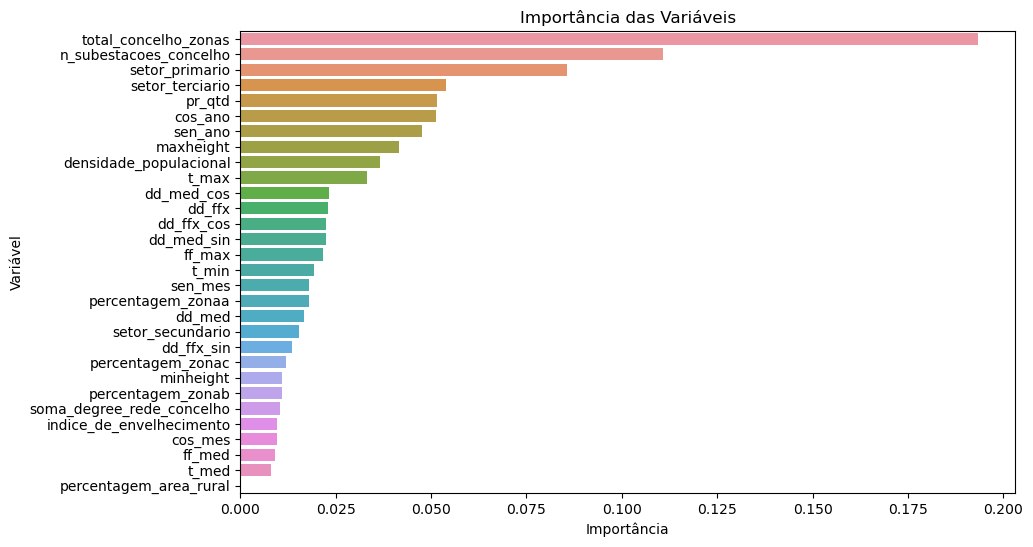

In [53]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig('UNDERFeatureImportance.png', format='png', bbox_inches='tight')
plt.show()


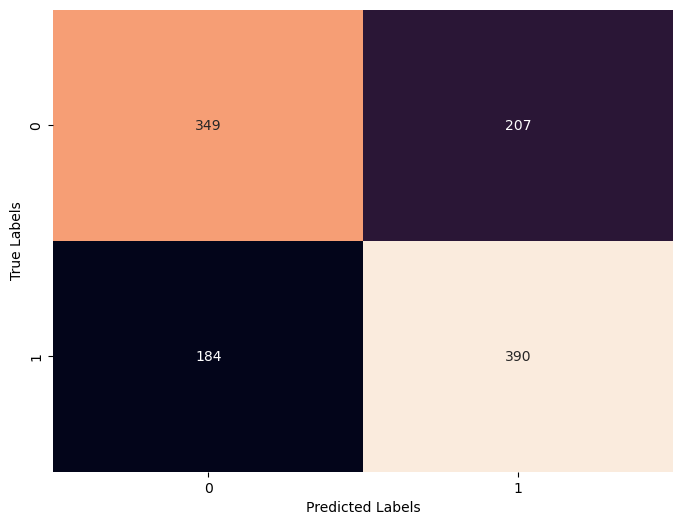

In [54]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Previsão da DB original - Modelo Under

In [55]:
X = QuebrasFinal.drop(columns=['HouveEvento?', 'n_incidentes', 'concelho', 'date', 'distrito', 'populacao_residente', 'rural', 'count_zonaa', 'count_zonab', 'count_zonac', 'perc_prim', 'perc_sec', 'perc_terc'])
y = QuebrasFinal['HouveEvento?']

# Fazer previsões na base de dados original
predictions = gb_model.predict(X)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions)
recall = recall_score(y, predictions)
f1 = f1_score(y, predictions)

print(f"Acurácia: {accuracy:.3f}")
print(f"Precisão: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Acurácia: 0.637
Precisão: 0.010
Recall: 0.740
F1-score: 0.020


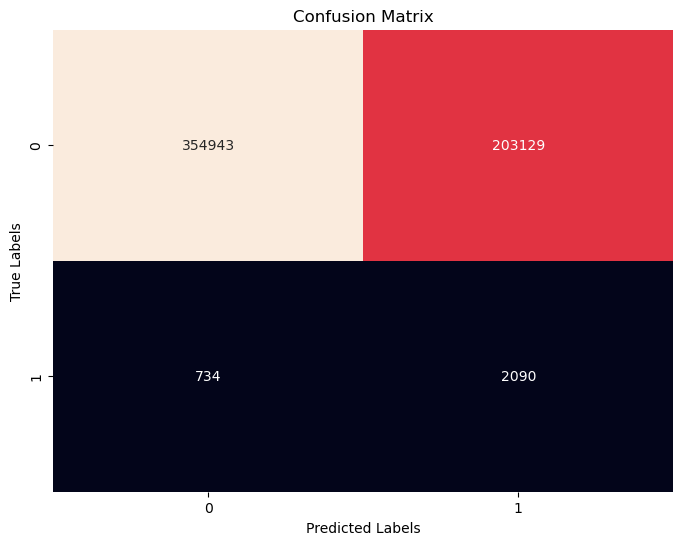

In [56]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y, predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('UNDERconfusionMatrix.png', format='png', bbox_inches='tight')
plt.show()